# Conservative Estimation using a Grid Seach Minimization

This notebook illustrates the different steps for a conservative estimation using a grid search minimization.

###### Classic Libraries

In [3]:
import openturns as ot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

## Additive model

The first example of conservative estimation consider an additive model $\eta : \mathbb R^d \rightarrow \mathbb R$ with Gaussian margins. The objectives are to estimate a quantity of interest $\mathcal C(Y)$ of the model output distribution. Unfortunately, the dependence structure is unknown. In order to be conservative we aim to give bounds to $\mathcal C(Y)$.

### The model
This example consider the simple additive example.

In [1]:
from dependence.tests import func_sum
help(func_sum)

Help on function func_sum in module dependence.tests.test_functions:

func_sum(x, a=None)
    Additive weighted model function.
    
    Parameters
    ----------
    x : np.ndarray
        The input values.
    a : np.ndarray
        The input coefficients.
        
    Returns
    -------
        y : a.x^t



### Dimension 2

We consider the problem in dimension $d=2$ and a number of pairs $p=1$ for gaussian margins.

In [4]:
dim = 2
margins = [ot.Normal()]*dim

#### Copula families

We consider a gaussian copula for this first example

In [5]:
families = np.zeros((dim, dim), dtype=int)
families[1, 0] = 1

#### Estimations
We create an instance of the main class for a conservative estimate.

In [6]:
from dependence import ConservativeEstimate

quant_estimate = ConservativeEstimate(model_func=func_sum, margins=margins, families=families)

We aim to minimize the output quantile. To do that, we create a `q_func` object from the function `quantile_func` to associate a probability $\alpha$ to a function that computes the empirical quantile from a given sample.

In [7]:
from dependence import quantile_func
alpha = 0.01
q_func = quantile_func(alpha)

First, we compute the quantile at independence

In [11]:
n = 20000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

The computation returns a `DependenceResult` instance. This object gather the informations of the computation. It also computes the output quantity of interest (which can also be changed).

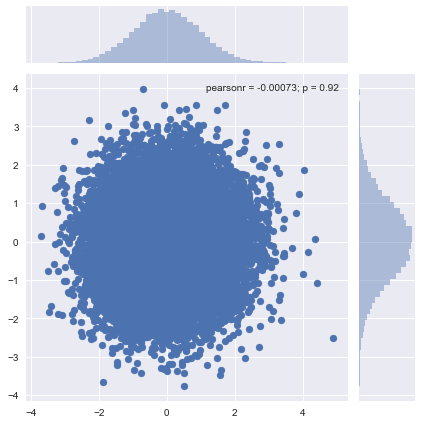

In [12]:
_ = sns.jointplot(indep_result.input_sample[:, 0], indep_result.input_sample[:, 1])

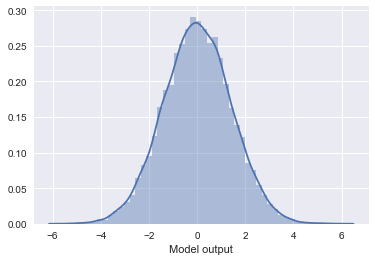

In [13]:
_ = sns.distplot(indep_result.output_sample[:, 0], axlabel='Model output')

In [14]:
print('Output quantile :', indep_result.quantity_)
indep_result.q_func = np.var
print('Output variance :', indep_result.quantity_)

('Output quantile :', -3.318036903793103)
('Output variance :', 1.9773353210105804)


A boostrap can be done on the output quantity

In [15]:
indep_result.q_func = q_func
indep_result.compute_bootstrap(n_bootstrap=1000)

And we can plot it

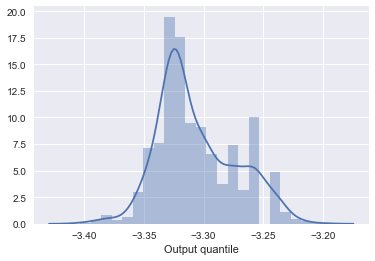

In [16]:
_ = sns.distplot(indep_result.bootstrap_sample[:, 0], axlabel='Output quantile')

In [17]:
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -3.31 with a C.O.V at 1.0 %


#### Grid Search Approach
Firstly, we consider a grid search approach in order to compare the perfomance with the iterative algorithm.

In [19]:
K = 30
n = 1000
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

The computation returns a `ListDependenceResult` which is a list of `DependenceResult` instances and some bonuses.

In [23]:
print('The computation did %d model evaluations.' % (grid_result.n_evals))

The computation did 30000 model evaluations.


What is the minimum quantile and what is it's value.

In [24]:
min_result = grid_result.min_result
print('Worst Quantile: %.2f at %.2f' % (min_result.quantity_, min_result.dep_param[0]))

Worst Quantile: -4.94 at 0.93


It can be seen by plotting the results

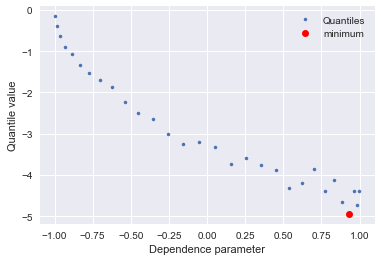

In [25]:
plt.plot(grid_result.dep_params, grid_result.quantities, '.', label='Quantiles')
plt.plot(min_result.dep_param[0], min_result.quantity_, 'ro', label='minimum')
plt.xlabel('Dependence parameter')
plt.ylabel('Quantile value')
plt.legend(loc=0)

In [32]:
grid_result.compute_bootstraps(n_bootstrap=1000)

array([[[-4.26067199],
        [-3.84972854],
        [-3.75113563],
        ..., 
        [-3.68032059],
        [-3.50325916],
        [-3.84977757]],

       [[-4.47380919],
        [-4.95350113],
        [-5.65122271],
        ..., 
        [-4.78150483],
        [-4.83996857],
        [-4.47481278]],

       [[-0.61211739],
        [-0.64946411],
        [-0.61646612],
        ..., 
        [-0.64951964],
        [-0.59154213],
        [-0.64934171]],

       ..., 
       [[-2.84388215],
        [-2.634405  ],
        [-2.7403968 ],
        ..., 
        [-2.58592035],
        [-2.634405  ],
        [-2.6345875 ]],

       [[-1.7887996 ],
        [-1.99621592],
        [-1.87623642],
        ..., 
        [-1.78561479],
        [-1.88322905],
        [-2.08136673]],

       [[-0.17456248],
        [-0.17460315],
        [-0.14681278],
        ..., 
        [-0.14992605],
        [-0.14463135],
        [-0.15223313]]])

As for the individual problem, we can do a boostrap also, for each parameters. Because we have $K$ parameters, we can do a bootstrap for the $K$ samples, compute the $K$ quantiles for all the bootstrap and get the minimum quantile for each bootstrap.

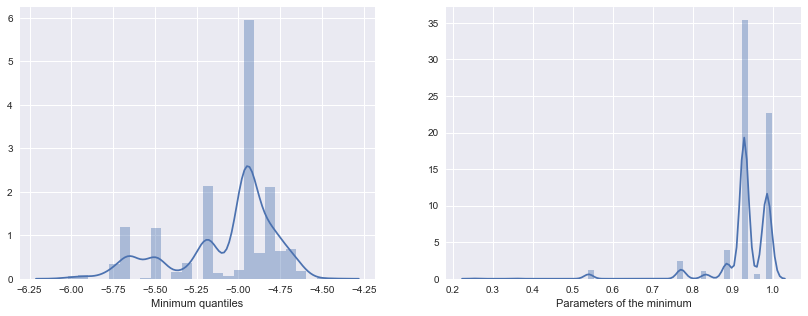

In [44]:
boot_min_quantiles = grid_result.bootstrap_samples.min(axis=0)
boot_argmin_quantiles = grid_result.bootstrap_samples.argmin(axis=0).ravel().tolist()
boot_min_params = [grid_result.dep_params[idx][0] for idx in boot_argmin_quantiles]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(boot_min_quantiles, axlabel="Minimum quantiles", ax=axes[0])
sns.distplot(boot_min_params, axlabel="Parameters of the minimum", ax=axes[1])

For the parameter that have the most occurence for the minimum, we compute its bootstrap mean.

In [45]:
 # The parameter with most occurence
boot_id_min = max(set(boot_argmin_quantiles), key=boot_argmin_quantiles.count)
boot_min_result = grid_result[boot_id_min]

boot_mean = boot_min_result.bootstrap_sample.mean()
boot_std = boot_min_result.bootstrap_sample.std()
print('Worst Quantile: %.2f at %.2f with a C.O.V at %.1f %%' % \
          (boot_mean, min_result.dep_param[0], abs(boot_std/boot_mean)*100.))

Worst Quantile: -4.92 at 0.93 with a C.O.V at 8.4 %


##### Kendall's Tau

An interesting feature is to convert the dependence parameters to Kendall's Tau values.

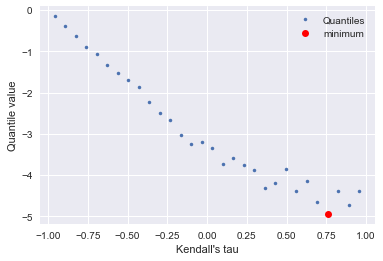

In [46]:
plt.plot(grid_result.kendalls, grid_result.quantities, '.', label='Quantiles')
plt.plot(min_result.kendall_tau, min_result.quantity_, 'ro', label='minimum')
plt.xlabel("Kendall's tau")
plt.ylabel('Quantile value')
plt.legend(loc=0)

#### With bounds on the dependencies

An interesting option in the `ConservativeEstimate` class is to bound the dependencies, due to some prior informations. 

In [47]:
bounds_tau = np.asarray([[0., 0.7], [0.1, 0.]])
quant_estimate.bounds_tau = bounds_tau
K = 20
n = 10000
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [48]:
min_result = grid_result.min_result
print('Worst Quantile: %.2f at %.2f' % (min_result.quantity_, min_result.dep_param[0]))

Worst Quantile: -4.59 at 0.88


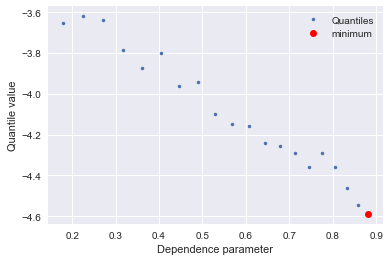

In [49]:
plt.plot(grid_result.dep_params, grid_result.quantities, '.', label='Quantiles')
plt.plot(min_result.dep_param[0], min_result.quantity_, 'ro', label='minimum')
plt.xlabel('Dependence parameter')
plt.ylabel('Quantile value')
plt.legend(loc=0)

#### Saving the results

It is usefull to save the result in a file to load it later and compute other quantities or anything you need!

In [50]:
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [51]:
grid_result.to_hdf('result.hdf5')

Data saved in result.hdf5


### Higher Dimension 

We consider the problem in dimension $d=5$.

In [52]:
dim = 5
margins = [ot.Normal()]*dim

#### Copula families with one dependent pair

We consider a gaussian copula for this first example, but for the moment only one pair is dependent.

In [53]:
families = np.zeros((dim, dim), dtype=int)
families[1, 0] = 1
families

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

We reset the families and bounds for the current instance. (I don't want to create a new instance, just to check if the setters are good).

In [54]:
from dependence import ConservativeEstimate

quant_estimate.margins = margins
quant_estimate.families = families
quant_estimate.vine_structure = None
quant_estimate.bounds_tau = None
quant_estimate.bounds_tau

Don't forget to change the family matrix.
Don't forget to change the structure matrix
Don't forget to change the vine_structure.


array([[ 0.  ,  0.99,  0.  ,  0.  ,  0.  ],
       [-0.99,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

Let's do the grid search to see

In [55]:
K = 20
n = 1000
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

The quantile is lower compare to the problem of dimension 1. Indeed, there is more variables, more uncertainty, so a larger deviation of the output.

In [56]:
min_result = grid_result.min_result
print('Worst Quantile: %.2f at %.2f' % (min_result.quantity_, min_result.dep_param[0]))

Worst Quantile: -6.01 at 1.00


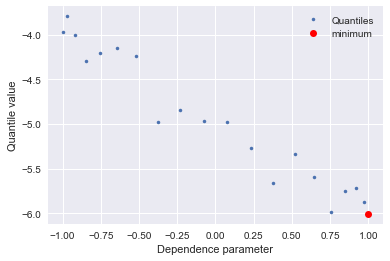

In [57]:
plt.plot(grid_result.dep_params, grid_result.quantities, '.', label='Quantiles')
plt.plot(min_result.dep_param[0], min_result.quantity_, 'ro', label='minimum')
plt.xlabel('Dependence parameter')
plt.ylabel('Quantile value')
plt.legend(loc=0)

#### Copula families with all dependent pairs

We consider a gaussian copula for this first example, but for the moment only one pair is dependent.

In [58]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

In [59]:
from dependence import ConservativeEstimate

quant_estimate.margins = margins
quant_estimate.families = families
quant_estimate.vine_structure = None
quant_estimate.bounds_tau = None
quant_estimate.bounds_tau

array([[ 0.  ,  0.99,  0.99,  0.99,  0.99],
       [-0.99,  0.  ,  0.99,  0.99,  0.99],
       [-0.99, -0.99,  0.  ,  0.99,  0.99],
       [-0.99, -0.99, -0.99,  0.  ,  0.99],
       [-0.99, -0.99, -0.99, -0.99,  0.  ]])

In [60]:
K = 100
n = 1000
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [61]:
min_result = grid_result.min_result
print('Worst Quantile: {0} at {1}'.format(min_result.quantity_, min_result.dep_param))

Worst Quantile: -10.8708019784 at [-0.96103527 -0.96916643  0.10864133  0.79408588  0.77480107  0.83033339
  0.81260263  0.46362081  0.99951148  0.99805621]
